In [1]:
import kagglehub
import os # We'll need this to join paths

print("--- Downloading dataset via kagglehub ---")
# This will download the dataset to a central cache folder
# and return the path to it.
path = kagglehub.dataset_download("ahmedhamdi906/tcga-pancan")

print(f"Dataset downloaded to: {path}")

# This 'path' variable is now the key. We'll use it in the next cell.

# --- NEW DEBUGGING CODE ---
print("\n--- Files in dataset folder: ---")
try:
    # List all files in the downloaded directory
    files_in_directory = os.listdir(path)
    for f in files_in_directory:
        print(f)
except Exception as e:
    print(f"Could not list files: {e}")
# --- END DEBUGGING CODE ---

C:\Users\dario\OneDrive\Desktop\Pancan project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Downloading dataset via kagglehub ---
Dataset downloaded to: C:\Users\dario\.cache\kagglehub\datasets\ahmedhamdi906\tcga-pancan\versions\6

--- Files in dataset folder: ---
annotations.csv
normal
TCGA-ACC
TCGA-BLCA
TCGA-BRCA
TCGA-CESC
TCGA-CHOL
TCGA-COAD
TCGA-DLBC
TCGA-ESCA
TCGA-GBM
TCGA-HNSC
TCGA-KICH
TCGA-KIRC
TCGA-KIRP
TCGA-LAML
TCGA-LGG
TCGA-LIHC
TCGA-LUAD
TCGA-LUSC
TCGA-MESO
TCGA-OV
TCGA-PAAD
TCGA-PCPG
TCGA-PRAD
TCGA-SARC
TCGA-SKCM
TCGA-STAD
TCGA-TGCT
TCGA-THCA
TCGA-THYM
TCGA-UCEC
TCGA-UCS
TCGA-UVM


In [2]:
import numpy as np
import joblib
import os
import gc

print("--- Loading PCA-Transformed Data from Disk ---")

PCA_SAVE_DIR = "pca_data"
DATA_LOADED_FROM_SAVE = False

try:
    # 1. Load the new, small PCA arrays
    X_train_pca = np.load(os.path.join(PCA_SAVE_DIR, 'X_train_pca.npy'))
    X_test_pca = np.load(os.path.join(PCA_SAVE_DIR, 'X_test_pca.npy'))
    
    # 2. Load the labels
    y_train = np.load(os.path.join(PCA_SAVE_DIR, 'y_train.npy'))
    y_test = np.load(os.path.join(PCA_SAVE_DIR, 'y_test.npy'))
    
    print("Successfully loaded PCA train/test data.")

    # 3. Load the fitted PCA model and encoder
    pca = joblib.load(os.path.join(PCA_SAVE_DIR, 'pca_model.joblib'))
    le = joblib.load("processed_data/label_encoder.joblib") # From our first save
    class_names = le.classes_
    
    print("Successfully loaded PCA model and label encoder.")
    print(f"X_train_pca shape: {X_train_pca.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"Total classes: {len(class_names)}")
    
    DATA_LOADED_FROM_SAVE = True

except FileNotFoundError:
    print("--- FATAL ERROR: PCA save files not found. ---")
    print("Please go back and run the full loading pipeline (Cells 1-9).")
except Exception as e:
    print(f"An error occurred loading files: {e}")

# Clean up any potential leftover variables from old runs
gc.collect()

--- Loading PCA-Transformed Data from Disk ---
Successfully loaded PCA train/test data.
Successfully loaded PCA model and label encoder.
X_train_pca shape: (3284, 300)
y_train shape: (3284,)
Total classes: 18


0

In [3]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import gc # Garbage Collector

if not DATA_LOADED_FROM_SAVE:

    print("--- Final NumPy Data Loading (Corrected miRNA Columns) ---")
    
    # 'path' is the variable from Cell 1
    ANNOTATIONS_PATH = os.path.join(path, 'annotations.csv')
    
    # --- 1. Load our "Master Map" ---
    try:
        annotations_df = pd.read_csv(ANNOTATIONS_PATH)
        annotations_df = annotations_df.dropna(subset=['id', 'OTHER_PATIENT_ID', 'SUBTYPE', 'CANCER_TYPE'])
        print(f"Loaded and cleaned annotations. {len(annotations_df)} patients to process.")
    except FileNotFoundError:
        print(f"Error: Could not find annotations file at {ANNOTATIONS_PATH}")
        raise
    
    # --- 2. Prepare lists to hold lightweight NumPy arrays ---
    all_rna_rows = []
    all_dna_rows = []
    all_mirna_rows = []
    all_cancer_types = []
    
    # --- 3. Prepare lists for feature names (for our report) ---
    column_names_rna = []
    column_names_dna = []
    column_names_mirna = []
    got_column_names = False # Flag to run this only once
    
    print("Looping through all patients...")
    # --- 4. Loop Through All Patients ---
    for row in tqdm(annotations_df.itertuples(), total=len(annotations_df)):
        
        main_patient_id = row.id
        patient_folder_id = row.OTHER_PATIENT_ID
        cancer_subtype = row.SUBTYPE
        cancer_type_label = row.CANCER_TYPE
        cancer_folder = f"TCGA-{cancer_subtype}"
        
        base_patient_path = os.path.join(path, cancer_folder, cancer_folder, patient_folder_id)
        rna_path = os.path.join(base_patient_path, 'RNA-seq.parquet')
        dna_path = os.path.join(base_patient_path, 'DNA-methylation.parquet')
        mirna_path = os.path.join(base_patient_path, 'mirna-seq.parquet')
        
        try:
            rna_df = pd.read_parquet(rna_path)
            dna_df = pd.read_parquet(dna_path)
            mirna_df = pd.read_parquet(mirna_path) 
    
            # Extract ONLY the value column and convert to NumPy
            rna_data = rna_df['tpm_unstranded'].to_numpy(dtype=np.float32)
            dna_data = dna_df['beta'].to_numpy(dtype=np.float32)
            # This line was correct all along:
            mirna_data = mirna_df['reads_per_million_miRNA_mapped'].to_numpy(dtype=np.float32) 
            
            all_rna_rows.append(rna_data)
            all_dna_rows.append(dna_data)
            all_mirna_rows.append(mirna_data)
            all_cancer_types.append(cancer_type_label)
            
            if not got_column_names:
                column_names_rna = [f'rna_{gid}' for gid in rna_df['gene_id']]
                column_names_dna = [f'dna_{sid}' for sid in dna_df['site']]
                # --- THIS IS THE ONE AND ONLY FIX ---
                # Changed 'mirna_id' to the correct 'miRNA_ID'
                column_names_mirna = [f'mirna_{s}' for s in mirna_df['miRNA_ID']] 
                
                print("Successfully captured feature names.")
                got_column_names = True
    
        except FileNotFoundError:
            pass 
        except Exception as e:
            # We shouldn't see this error anymore
            print(f"Error processing patient {main_patient_id}: {e}")
            break 
    
    print(f"\nSuccessfully loaded data for {len(all_cancer_types)} patients.")
    
    # --- 5. Final Assembly (NumPy) ---
    if got_column_names and len(all_cancer_types) > 0:
        print("Stacking NumPy arrays...")
        try:
            rna_np = np.stack(all_rna_rows)
            dna_np = np.stack(all_dna_rows)
            mirna_np = np.stack(all_mirna_rows)
    
            print(f"RNA matrix shape: {rna_np.shape}")
            print(f"DNA matrix shape: {dna_np.shape}")
            print(f"miRNA matrix shape: {mirna_np.shape}")
    
            X = np.concatenate([rna_np, dna_np, mirna_np], axis=1)
            y = np.array(all_cancer_types)
            all_feature_names = column_names_rna + column_names_dna + column_names_mirna
            
            del all_rna_rows, all_dna_rows, all_mirna_rows, rna_np, dna_np, mirna_np, rna_df, dna_df, mirna_df
            gc.collect() 
    
            print("\n--- Data Loading Complete! ---")
            print(f"Final features matrix (X) shape: {X.shape}")
            print(f"Final target vector (y) shape: {y.shape}")
            print(f"Total features: {len(all_feature_names)}")
    
        except Exception as e:
            print(f"Error during final NumPy stacking: {e}")
            print("This can happen if some patient files have different numbers of features.")
    else:
        print("\nData loading was not fully completed due to an error.")

--- EDA: Class Balance Check (Using Loaded PCA Data Labels) ---
Class Distribution (Top 10):
Cancer Type
Non-Small Cell Lung Cancer        790
Thyroid Cancer                    479
Prostate Cancer                   475
Bladder Cancer                    394
Melanoma                          349
Hepatobiliary Cancer              344
Renal Non-Clear Cell Carcinoma    323
Renal Clear Cell Carcinoma        255
Pancreatic Cancer                 152
Pheochromocytoma                  134
Name: count, dtype: int64

Total unique classes: 18
Largest class size: 790
Smallest class size: 8

--- NOTE: Data is Highly Imbalanced! ---


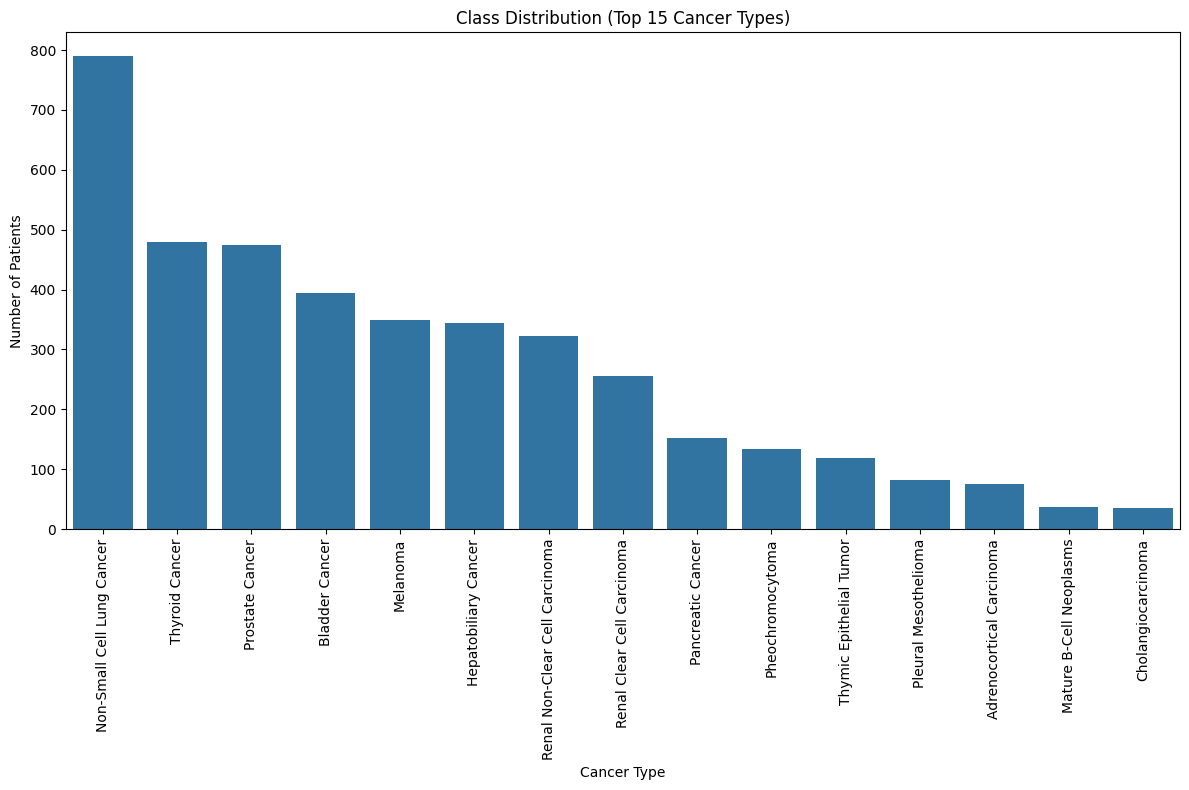

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Need numpy for concatenate

print("--- EDA: Class Balance Check (Using Loaded PCA Data Labels) ---")

# Check if the necessary label data loaded by Cell 2 exists
if 'y_test' in locals() and 'y_train' in locals() and 'le' in locals() and DATA_LOADED_FROM_SAVE:

    # Combine train and test labels to get the original distribution
    y_combined_encoded = np.concatenate((y_train, y_test))
    # Decode back to original string labels using the loaded label encoder 'le'
    y_combined_labels = le.inverse_transform(y_combined_encoded)

    y_series = pd.Series(y_combined_labels, name="Cancer Type")
    class_counts = y_series.value_counts()

    print("Class Distribution (Top 10):")
    print(class_counts.head(10))
    print(f"\nTotal unique classes: {len(class_counts)}")

    # 2. Check for imbalance (Informational)
    min_class_size = class_counts.min()
    max_class_size = class_counts.max()
    print(f"Largest class size: {max_class_size}")
    print(f"Smallest class size: {min_class_size}")
    if max_class_size > min_class_size * 10:
        print("\n--- NOTE: Data is Highly Imbalanced! ---")
    else:
        print("\nData is reasonably balanced.")

    # 3. Plot the distribution
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=class_counts.head(15).index,
        y=class_counts.head(15).values
    )
    plt.title('Class Distribution (Top 15 Cancer Types)')
    plt.ylabel('Number of Patients')
    plt.xlabel('Cancer Type')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Add a case for when we haven't loaded from save (i.e., first run)
elif 'y' in locals() and not DATA_LOADED_FROM_SAVE:
    print("Generating plot from newly loaded raw 'y' data...")
    # This part is the same as the original attempt, using the raw 'y'
    y_series = pd.Series(y, name="Cancer Type")
    class_counts = y_series.value_counts()
    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_counts.head(15).index, y=class_counts.head(15).values)
    plt.title('Class Distribution (Top 15 Cancer Types)')
    plt.ylabel('Number of Patients'); plt.xlabel('Cancer Type')
    plt.xticks(rotation=90); plt.tight_layout(); plt.show()

else:
    print("Error: Required data (y_train, y_test, le OR raw y) not found.")
    print("Please run the PCA data loader cell (Cell 2) or ensure raw data loading (Cell 3) completed if it's the first run.")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import gc

if not DATA_LOADED_FROM_SAVE:

    print("\n--- Data Preprocessing Started ---")
    
    if 'X' not in locals() or 'y' not in locals():
        print("Error: 'X' and 'y' arrays not found. Please run the data loading cell first.")
    else:
        # --- 4.1 Check for Missing Values (in NumPy) ---
        if np.isnan(X).any():
            print("Warning: Found NaN values in X. Replacing NaNs with 0.")
            X = np.nan_to_num(X, nan=0.0)
            print("NaN values replaced.")
        
        # --- 4.2 Encode Target Variable (y) ---
        print("Encoding target variable (y)...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        print(f"Total classes: {len(le.classes_)}")
        np.save('cancer_classes.npy', le.classes_)
    
        # --- 4.3 Create Training and Test Splits ---
        print("Splitting data into train and test sets...")
        # 'stratify=y_encoded' is CRITICAL here due to the imbalance
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, 
            test_size=0.2, 
            random_state=42, 
            stratify=y_encoded 
        )
    
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")
    
        # --- 4.4 Apply Feature Scaling ---
        print("Applying feature scaling (StandardScaler)...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    
        print("--- Feature Scaling Complete ---")
        print("Data is now preprocessed and ready for modeling.")
    
        # --- 4.5 Clean up memory ---
        del X, y, X_train, X_test
        gc.collect()

In [6]:
import numpy as np
import joblib
import os

if not DATA_LOADED_FROM_SAVE:    

    print("--- Saving Data and Objects to Disk ---")
    
    # Define a folder to store our save files
    SAVE_DIR = "processed_data"
    os.makedirs(SAVE_DIR, exist_ok=True) # Create the folder if it doesn't exist
    
    try:
        # 1. Save the main data arrays
        np.save(os.path.join(SAVE_DIR, 'X_train_scaled.npy'), X_train_scaled)
        np.save(os.path.join(SAVE_DIR, 'X_test_scaled.npy'), X_test_scaled)
        np.save(os.path.join(SAVE_DIR, 'y_train.npy'), y_train)
        np.save(os.path.join(SAVE_DIR, 'y_test.npy'), y_test)
        
        print("Successfully saved train/test data arrays.")
    
        # 2. Save the fitted scaler (CRITICAL for future predictions)
        joblib.dump(scaler, os.path.join(SAVE_DIR, 'scaler.joblib'))
        print("Successfully saved the scaler.")
        
        # 3. Save the fitted label encoder (CRITICAL for reading results)
        joblib.dump(le, os.path.join(SAVE_DIR, 'label_encoder.joblib'))
        print("Successfully saved the label encoder.")
        
        # 4. Save the feature names (CRITICAL for the report)
        # We need to load 'all_feature_names' from memory (if it's not there, re-run Cell 2)
        if 'all_feature_names' in locals():
            np.save(os.path.join(SAVE_DIR, 'all_feature_names.npy'), all_feature_names)
            print("Successfully saved feature names.")
        else:
            print("Warning: 'all_feature_names' not in memory. Run Cell 2 to generate it.")
            
        print(f"\n--- All files saved to the '{SAVE_DIR}' folder! ---")
    
    except NameError as e:
        print(f"Error: A required variable was not found. {e}")
        print("Please ensure Cell 2 (Loading) and Cell 4 (Preprocessing) have been run successfully.")
    except Exception as e:
        print(f"An error occurred during saving: {e}")

In [7]:
from sklearn.decomposition import PCA
import numpy as np
import time
import gc

if not DATA_LOADED_FROM_SAVE:    

    print("--- Feature Engineering: Applying PCA ---")
    
    if DATA_LOADED_FROM_SAVE:
        # We'll reduce our 548k features to 300 components
        # 300 is a common, powerful choice.
        N_COMPONENTS = 300
        
        pca = PCA(n_components=N_COMPONENTS, random_state=42)
        
        # 1. Fit PCA ONLY on the training data
        print(f"Fitting PCA to {N_COMPONENTS} components...")
        start_time = time.time()
        pca.fit(X_train_scaled)
        end_time = time.time()
        print(f"PCA fitting complete in {end_time - start_time:.2f} seconds.")
    
        # 2. Transform BOTH train and test data
        print("Transforming train and test data...")
        X_train_pca = pca.transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        # 3. Check Explained Variance
        # This is a key metric for your report!
        explained_variance = np.sum(pca.explained_variance_ratio_)
        print(f"\n--- PCA Summary ---")
        print(f"Original shape: {X_train_scaled.shape}")
        print(f"New PCA shape:  {X_train_pca.shape}")
        print(f"Total variance explained by {N_COMPONENTS} components: {explained_variance * 100:.2f}%")
    
        # 4. CRITICAL: Clean up memory
        # We can now delete the giant 14GB+ arrays
        print("\nCleaning up large scaled arrays...")
        del X_train_scaled, X_test_scaled
        gc.collect() # Force garbage collection
        print("Memory cleaned. Ready for modeling.")
    
    else:
        print("Data not loaded. Please run the loader cell first.")

In [8]:
import numpy as np
import joblib
import os

if not DATA_LOADED_FROM_SAVE:    
    print("--- Saving PCA-Transformed Data ---")
    
    PCA_SAVE_DIR = "pca_data"
    os.makedirs(PCA_SAVE_DIR, exist_ok=True) 
    
    try:
        # 1. Save the new, small PCA arrays
        np.save(os.path.join(PCA_SAVE_DIR, 'X_train_pca.npy'), X_train_pca)
        np.save(os.path.join(PCA_SAVE_DIR, 'X_test_pca.npy'), X_test_pca)
        
        # We still need the original labels
        np.save(os.path.join(PCA_SAVE_DIR, 'y_train.npy'), y_train)
        np.save(os.path.join(PCA_SAVE_DIR, 'y_test.npy'), y_test)
        
        print("Successfully saved PCA train/test data.")
    
        # 2. Save the fitted PCA object
        # This is critical for processing new data in the future
        joblib.dump(pca, os.path.join(PCA_SAVE_DIR, 'pca_model.joblib'))
        print("Successfully saved the fitted PCA model.")
        
        print(f"\n--- All PCA files saved to the '{PCA_SAVE_DIR}' folder! ---")
    
    except NameError as e:
        print(f"Error: A required variable was not found. {e}")
    except Exception as e:
        print(f"An error occurred during saving: {e}")

In [9]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import time # To time our model training

print("--- Model 1: Logistic Regression (on PCA Data) ---")

if DATA_LOADED_FROM_SAVE:
    # --- 1. Train the Model ---
    print("Training Logistic Regression model...")
    log_reg = LogisticRegression(n_jobs=-1, C=1.0, random_state=42, max_iter=1000)
    
    start_time = time.time()
    # --- THE FIX ---
    log_reg.fit(X_train_pca, y_train)
    # --- END FIX ---
    end_time = time.time()
    
    print(f"Training complete in {end_time - start_time:.2f} seconds.")

    # --- 2. Make Predictions ---
    print("Making predictions on the test set...")
    # --- THE FIX ---
    y_pred_log_reg = log_reg.predict(X_test_pca)
    # --- END FIX ---

    # --- 3. Evaluate the Model ---
    print("\n--- Evaluation: Logistic Regression (PCA) ---")
    accuracy = accuracy_score(y_test, y_pred_log_reg)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    
    print("\nClassification Report:")
    report = classification_report(
        y_test, y_pred_log_reg, target_names=class_names, zero_division=0
    )
    print(report)
    
    report_data = classification_report(
        y_test, y_pred_log_reg, target_names=class_names, 
        output_dict=True, zero_division=0
    )
    log_reg_report_df = pd.DataFrame(report_data).transpose()
    print("\nReport saved to 'log_reg_report_df'.")

else:
    print("Data not loaded. Please run the loader cell first.")

--- Model 1: Logistic Regression (on PCA Data) ---
Training Logistic Regression model...
Training complete in 1.84 seconds.
Making predictions on the test set...

--- Evaluation: Logistic Regression (PCA) ---
Overall Accuracy: 97.32%

Classification Report:
                                     precision    recall  f1-score   support

           Adrenocortical Carcinoma       1.00      1.00      1.00        15
                     Bladder Cancer       0.99      0.96      0.97        79
                 Cholangiocarcinoma       1.00      1.00      1.00         7
                 Endometrial Cancer       0.83      1.00      0.91         5
               Hepatobiliary Cancer       1.00      0.99      0.99        69
            Mature B-Cell Neoplasms       1.00      1.00      1.00         7
                           Melanoma       0.99      1.00      0.99        70
Miscellaneous Neuroepithelial Tumor       0.33      0.20      0.25         5
         Non-Small Cell Lung Cancer       0.96  

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

print("--- Model 2: Random Forest Classifier (on PCA Data) ---")

if DATA_LOADED_FROM_SAVE:
    print("Training Random Forest model (using all CPU cores)...")
    rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    # --- THE FIX ---
    rf_model.fit(X_train_pca, y_train)
    # --- END FIX ---
    end_time = time.time()
    
    print(f"Training complete in {end_time - start_time:.2f} seconds.")

    print("Making predictions on the test set...")
    # --- THE FIX ---
    y_pred_rf = rf_model.predict(X_test_pca)
    # --- END FIX ---

    print("\n--- Evaluation: Random Forest (PCA) ---")
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Overall Accuracy: {accuracy_rf * 100:.2f}%")
    
    print("\nClassification Report:")
    report_rf = classification_report(
        y_test, y_pred_rf, target_names=class_names, zero_division=0
    )
    print(report_rf)
    
    report_data_rf = classification_report(
        y_test, y_pred_rf, target_names=class_names, 
        output_dict=True, zero_division=0
    )
    rf_report_df = pd.DataFrame(report_data_rf).transpose()
    print("\nReport saved to 'rf_report_df'.")
else:
    print("Data not loaded. Please run the loader cell first.")

--- Model 2: Random Forest Classifier (on PCA Data) ---
Training Random Forest model (using all CPU cores)...
Training complete in 0.36 seconds.
Making predictions on the test set...

--- Evaluation: Random Forest (PCA) ---
Overall Accuracy: 95.13%

Classification Report:
                                     precision    recall  f1-score   support

           Adrenocortical Carcinoma       1.00      0.87      0.93        15
                     Bladder Cancer       1.00      0.92      0.96        79
                 Cholangiocarcinoma       0.86      0.86      0.86         7
                 Endometrial Cancer       1.00      0.80      0.89         5
               Hepatobiliary Cancer       1.00      0.97      0.99        69
            Mature B-Cell Neoplasms       1.00      0.86      0.92         7
                           Melanoma       0.97      0.99      0.98        70
Miscellaneous Neuroepithelial Tumor       1.00      0.40      0.57         5
         Non-Small Cell Lung Canc

In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

print("--- Model 3: XGBoost Classifier (on PCA Data, CPU) ---")

if DATA_LOADED_FROM_SAVE:
    print("Training XGBoost model (using fast CPU 'hist' method)...")
    num_classes = len(le.classes_) 
    
    xgb_model = xgb.XGBClassifier(
        tree_method='hist', 
        objective='multi:softmax', 
        num_class=num_classes,
        random_state=42,
        eval_metric='mlogloss',
        early_stopping_rounds=10,
        n_jobs=-1 # Use all CPU cores
    )
    
    start_time = time.time()
    # --- THE FIX ---
    xgb_model.fit(
        X_train_pca, 
        y_train, 
        eval_set=[(X_test_pca, y_test)], # Use PCA data for validation
        verbose=False 
    )
    # --- END FIX ---
    end_time = time.time()
    
    print(f"Training complete in {end_time - start_time:.2f} seconds.")

    print("Making predictions on the test set...")
    # --- THE FIX ---
    y_pred_xgb = xgb_model.predict(X_test_pca)
    # --- END FIX ---

    print("\n--- Evaluation: XGBoost (PCA) ---")
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"Overall Accuracy: {accuracy_xgb * 100:.2f}%")
    
    print("\nClassification Report:")
    report_xgb = classification_report(
        y_test, y_pred_xgb, target_names=class_names, zero_division=0
    )
    print(report_xgb)
    
    report_data_xgb = classification_report(
        y_test, y_pred_xgb, target_names=class_names, 
        output_dict=True, zero_division=0
    )
    xgb_report_df = pd.DataFrame(report_data_xgb).transpose()
    print("\nReport saved to 'xgb_report_df'.")
else:
    print("Data not loaded. Please run the loader cell first.")

--- Model 3: XGBoost Classifier (on PCA Data, CPU) ---
Training XGBoost model (using fast CPU 'hist' method)...
Training complete in 4.10 seconds.
Making predictions on the test set...

--- Evaluation: XGBoost (PCA) ---
Overall Accuracy: 95.50%

Classification Report:
                                     precision    recall  f1-score   support

           Adrenocortical Carcinoma       1.00      0.87      0.93        15
                     Bladder Cancer       0.96      0.95      0.96        79
                 Cholangiocarcinoma       0.78      1.00      0.88         7
                 Endometrial Cancer       0.80      0.80      0.80         5
               Hepatobiliary Cancer       0.97      0.94      0.96        69
            Mature B-Cell Neoplasms       1.00      1.00      1.00         7
                           Melanoma       0.99      1.00      0.99        70
Miscellaneous Neuroepithelial Tumor       1.00      0.20      0.33         5
         Non-Small Cell Lung Cancer  

### Now we are going to tune our previous models to see if we can improve their performances.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

print("--- Model 1 (Optimized): Logistic Regression with GridSearchCV ---")

if DATA_LOADED_FROM_SAVE:
    
    # --- 1. Define the Parameter Grid ---
    # We will test different regularization strengths ('C')
    # and different penalties ('l1', 'l2')
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'solver': ['saga'], # 'saga' is a good solver that supports both penalties
        'penalty': ['l1', 'l2'] 
    }
    
    print(f"Parameter grid: {param_grid}")
    
    # --- 2. Set up GridSearchCV ---
    # cv=3 means 3-fold cross-validation
    # scoring='weighted_f1' is the right metric for imbalanced data
    # n_jobs=-1 will use all your CPU cores
    grid_search_lr = GridSearchCV(
        estimator=LogisticRegression(random_state=42, max_iter=5000), # Increased max_iter
        param_grid=param_grid,
        scoring='f1_weighted', 
        cv=3,
        n_jobs=-1,
        verbose=1 # This will print updates
    )
    
    # --- 3. Run the Search ---
    print("\nRunning GridSearchCV... This will take a few minutes.")
    start_time = time.time()
    grid_search_lr.fit(X_train_pca, y_train)
    end_time = time.time()
    
    print(f"Grid search complete in {end_time - start_time:.2f} seconds.")
    
    # --- 4. Show Best Parameters ---
    print(f"\nBest parameters found: {grid_search_lr.best_params_}")
    print(f"Best weighted F1-score (from CV): {grid_search_lr.best_score_:.4f}")
    
    # --- 5. Evaluate the BEST Model on the Test Set ---
    print("\nMaking predictions with the *best* model...")
    best_log_reg = grid_search_lr.best_estimator_
    y_pred_best_lr = best_log_reg.predict(X_test_pca)
    
    print("\n--- Evaluation: Optimized Logistic Regression ---")
    accuracy_best_lr = accuracy_score(y_test, y_pred_best_lr)
    print(f"Overall Accuracy: {accuracy_best_lr * 100:.2f}%")
    
    print("\nClassification Report (Optimized):")
    report_best_lr = classification_report(
        y_test, 
        y_pred_best_lr, 
        target_names=class_names,
        zero_division=0
    )
    print(report_best_lr)

else:
    print("Data not loaded. Please run the loader cell (Cell 1) first.")

--- Model 1 (Optimized): Logistic Regression with GridSearchCV ---
Parameter grid: {'C': [0.01, 0.1, 1.0, 10.0], 'solver': ['saga'], 'penalty': ['l1', 'l2']}

Running GridSearchCV... This will take a few minutes.
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Grid search complete in 393.53 seconds.

Best parameters found: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
Best weighted F1-score (from CV): 0.9769

Making predictions with the *best* model...

--- Evaluation: Optimized Logistic Regression ---
Overall Accuracy: 97.45%

Classification Report (Optimized):
                                     precision    recall  f1-score   support

           Adrenocortical Carcinoma       1.00      1.00      1.00        15
                     Bladder Cancer       0.99      0.97      0.98        79
                 Cholangiocarcinoma       1.00      1.00      1.00         7
                 Endometrial Cancer       0.83      1.00      0.91         5
               Hepatobiliary Canc

In [13]:
# Cell 6 code (same as before)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

print("--- Model 2 (Optimized): Random Forest with Class Weighting ---")

if DATA_LOADED_FROM_SAVE:
    print("Training 'Balanced' Random Forest model (using all CPU cores)...")
    
    rf_balanced_model = RandomForestClassifier(
        n_estimators=100, 
        n_jobs=-1, 
        random_state=42,
        class_weight='balanced' # <--- THE OPTIMIZATION
    )
    
    start_time = time.time()
    rf_balanced_model.fit(X_train_pca, y_train)
    end_time = time.time()
    
    print(f"Training complete in {end_time - start_time:.2f} seconds.")

    print("Making predictions on the test set...")
    y_pred_rf_balanced = rf_balanced_model.predict(X_test_pca)

    print("\n--- Evaluation: 'Balanced' Random Forest ---")
    accuracy_rf_balanced = accuracy_score(y_test, y_pred_rf_balanced)
    print(f"Overall Accuracy: {accuracy_rf_balanced * 100:.2f}%")
    
    print("\nClassification Report (Balanced):")
    report_rf_balanced = classification_report(
        y_test, 
        y_pred_rf_balanced, 
        target_names=class_names,
        zero_division=0
    )
    print(report_rf_balanced)

else:
    print("Data not loaded. Please run the loader cell (Cell 1) first.")

--- Model 2 (Optimized): Random Forest with Class Weighting ---
Training 'Balanced' Random Forest model (using all CPU cores)...
Training complete in 0.47 seconds.
Making predictions on the test set...

--- Evaluation: 'Balanced' Random Forest ---
Overall Accuracy: 95.38%

Classification Report (Balanced):
                                     precision    recall  f1-score   support

           Adrenocortical Carcinoma       1.00      0.80      0.89        15
                     Bladder Cancer       0.99      0.92      0.95        79
                 Cholangiocarcinoma       0.88      1.00      0.93         7
                 Endometrial Cancer       1.00      0.80      0.89         5
               Hepatobiliary Cancer       1.00      0.97      0.99        69
            Mature B-Cell Neoplasms       1.00      1.00      1.00         7
                           Melanoma       0.96      0.99      0.97        70
Miscellaneous Neuroepithelial Tumor       1.00      0.40      0.57         

In [14]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

print("--- Model 3 (Optimized): XGBoost with GridSearchCV ---")

if DATA_LOADED_FROM_SAVE:

    # --- 1. Define the Parameter Grid ---
    # We'll test a few common parameters for XGBoost
    param_grid_xgb = {
        'max_depth': [3, 5],            # Depth of the trees
        'learning_rate': [0.01, 0.1],   # How fast the model learns
        'n_estimators': [100, 200]    # Number of trees
    }

    print(f"Parameter grid: {param_grid_xgb}")

    # --- 2. Set up GridSearchCV ---
    num_classes = len(le.classes_)

    # Note: 'hist' is the tree_method. 'mlogloss' is the eval_metric.
    xgb_estimator = xgb.XGBClassifier(
        tree_method='hist',
        objective='multi:softmax',
        num_class=num_classes,
        random_state=42,
        n_jobs=-1 # Use all cores for the *estimator* itself
    )

    grid_search_xgb = GridSearchCV(
        estimator=xgb_estimator,
        param_grid=param_grid_xgb,
        scoring='f1_weighted', # Correct scoring metric
        cv=3,
        n_jobs=-1, # Use all cores for the *GridSearch CV*
        verbose=1
    )

    # --- 3. Run the Search ---
    print("\nRunning GridSearchCV for XGBoost... This will take a few minutes.")
    start_time = time.time()
    grid_search_xgb.fit(X_train_pca, y_train) # Fit on PCA data
    end_time = time.time()

    print(f"Grid search complete in {end_time - start_time:.2f} seconds.")

    # --- 4. Show Best Parameters ---
    print(f"\nBest parameters found: {grid_search_xgb.best_params_}")
    print(f"Best weighted F1-score (from CV): {grid_search_xgb.best_score_:.4f}")

    # --- 5. Evaluate the BEST Model on the Test Set ---
    print("\nMaking predictions with the *best* XGBoost model...")
    best_xgb = grid_search_xgb.best_estimator_
    y_pred_best_xgb = best_xgb.predict(X_test_pca) # Predict on PCA test data

    print("\n--- Evaluation: Optimized XGBoost ---")
    accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
    print(f"Overall Accuracy: {accuracy_best_xgb * 100:.2f}%")

    print("\nClassification Report (Optimized):")
    report_best_xgb = classification_report(
        y_test,
        y_pred_best_xgb,
        target_names=class_names,
        zero_division=0
    )
    print(report_best_xgb)

else:
    print("Data not loaded. Please run the loader cell (Cell 1) first.")

--- Model 3 (Optimized): XGBoost with GridSearchCV ---
Parameter grid: {'max_depth': [3, 5], 'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]}

Running GridSearchCV for XGBoost... This will take a few minutes.
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Grid search complete in 97.49 seconds.

Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best weighted F1-score (from CV): 0.9563

Making predictions with the *best* XGBoost model...

--- Evaluation: Optimized XGBoost ---
Overall Accuracy: 95.50%

Classification Report (Optimized):
                                     precision    recall  f1-score   support

           Adrenocortical Carcinoma       1.00      0.80      0.89        15
                     Bladder Cancer       0.99      0.95      0.97        79
                 Cholangiocarcinoma       0.88      1.00      0.93         7
                 Endometrial Cancer       0.80      0.80      0.80         5
               Hepa

--- Plotting Full Model Comparison (Weighted Avg F1-Score) ---
All necessary prediction variables found or regenerated.


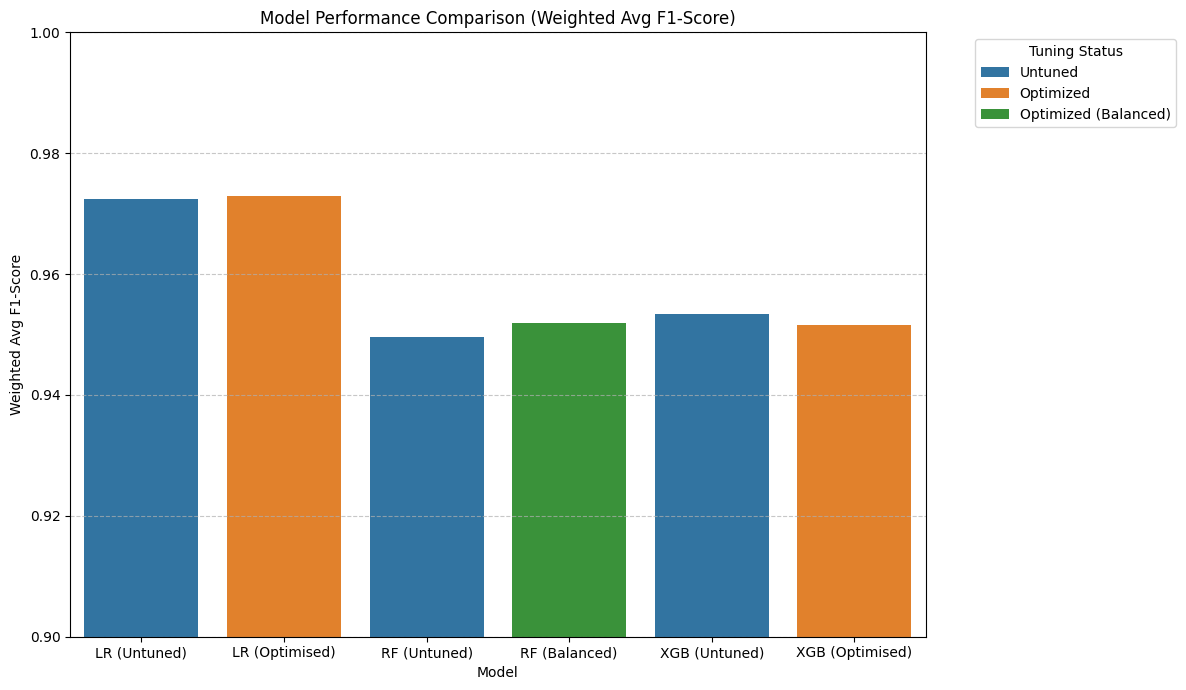


Comparison DataFrame:
             Model  F1-Score                Tuning
0     LR (Untuned)  0.972479               Untuned
1   LR (Optimised)  0.972843             Optimized
2     RF (Untuned)  0.949593               Untuned
3    RF (Balanced)  0.951885  Optimized (Balanced)
4    XGB (Untuned)  0.953352               Untuned
5  XGB (Optimised)  0.951573             Optimized


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
# Import models just in case we need to refit briefly
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import time
import gc # Garbage Collector

print("--- Plotting Full Model Comparison (Weighted Avg F1-Score) ---")

# --- Ensure prediction variables exist (re-run predict if needed) ---
# This is a safety net in case the kernel was restarted

try: # Wrap everything in a try block to catch missing data errors

    # Check/Regenerate Untuned LogReg
    if 'y_pred_log_reg' not in locals():
        print("Regenerating untuned LogReg predictions...")
        log_reg_untuned = LogisticRegression(n_jobs=-1, C=1.0, random_state=42, max_iter=1000)
        log_reg_untuned.fit(X_train_pca, y_train) 
        y_pred_log_reg = log_reg_untuned.predict(X_test_pca) 

    # Check/Regenerate Untuned RF
    if 'y_pred_rf' not in locals():
        print("Regenerating untuned RF predictions...")
        rf_untuned = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
        rf_untuned.fit(X_train_pca, y_train)
        y_pred_rf = rf_untuned.predict(X_test_pca)
        
    # Check/Regenerate Untuned XGBoost
    if 'y_pred_xgb' not in locals():
        print("Regenerating untuned XGBoost predictions...")
        num_classes = len(le.classes_)
        xgb_untuned = xgb.XGBClassifier(
            tree_method='hist', objective='multi:softmax', num_class=num_classes,
            random_state=42, n_jobs=-1
        )
        xgb_untuned.fit(X_train_pca, y_train) 
        y_pred_xgb = xgb_untuned.predict(X_test_pca) 

    # Check Optimized LR (assuming y_pred_best_lr exists from GridSearchCV cell)
    if 'y_pred_best_lr' not in locals():
         raise NameError("Optimized Logistic Regression predictions ('y_pred_best_lr') not found. Please run the GridSearchCV cell.")

    # Check Optimized RF (assuming y_pred_rf_balanced exists from balanced RF cell)
    if 'y_pred_rf_balanced' not in locals():
        raise NameError("Balanced Random Forest predictions ('y_pred_rf_balanced') not found. Please run the balanced RF cell.")

    # Check Optimized XGBoost (assuming y_pred_best_xgb exists from GridSearchCV cell)
    if 'y_pred_best_xgb' not in locals():
        raise NameError("Optimized XGBoost predictions ('y_pred_best_xgb') not found. Please run the XGBoost GridSearchCV cell.")
        
    print("All necessary prediction variables found or regenerated.")

    # --- Extract the scores using classification_report dictionaries ---
    
    # Generate reports as dictionaries directly
    report_lr_untuned_dict = classification_report(y_test, y_pred_log_reg, target_names=class_names, output_dict=True, zero_division=0)
    report_lr_opt_dict = classification_report(y_test, y_pred_best_lr, target_names=class_names, output_dict=True, zero_division=0)
    report_rf_untuned_dict = classification_report(y_test, y_pred_rf, target_names=class_names, output_dict=True, zero_division=0)
    report_rf_balanced_dict = classification_report(y_test, y_pred_rf_balanced, target_names=class_names, output_dict=True, zero_division=0)
    report_xgb_untuned_dict = classification_report(y_test, y_pred_xgb, target_names=class_names, output_dict=True, zero_division=0)
    report_xgb_opt_dict = classification_report(y_test, y_pred_best_xgb, target_names=class_names, output_dict=True, zero_division=0)

    scores = {
        'Model': [
            'LR (Untuned)', 
            'LR (Optimised)', 
            'RF (Untuned)', 
            'RF (Balanced)',
            'XGB (Untuned)', 
            'XGB (Optimised)'
            ],
        'F1-Score': [
            report_lr_untuned_dict['weighted avg']['f1-score'],
            report_lr_opt_dict['weighted avg']['f1-score'],
            report_rf_untuned_dict['weighted avg']['f1-score'], # Added
            report_rf_balanced_dict['weighted avg']['f1-score'], # Added
            report_xgb_untuned_dict['weighted avg']['f1-score'],
            report_xgb_opt_dict['weighted avg']['f1-score']
        ],
        'Tuning': ['Untuned', 'Optimized', 'Untuned', 'Optimized (Balanced)', 'Untuned', 'Optimized'] # Updated Tuning labels
    }

    scores_df = pd.DataFrame(scores)

    # --- Create the plot ---
    plt.figure(figsize=(12, 7)) # Made figure wider
    sns.barplot(data=scores_df, x='Model', y='F1-Score', hue='Tuning', dodge=False)

    plt.title('Model Performance Comparison (Weighted Avg F1-Score)')
    plt.ylabel('Weighted Avg F1-Score')
    plt.xlabel('Model')
    plt.xticks(rotation=0) 
    plt.ylim(0.9, 1.0) # Zoom in 
    plt.legend(title='Tuning Status', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() 
    plt.show()

    print("\nComparison DataFrame:")
    print(scores_df)
    
    # Clean up potentially large regenerated models
    if 'log_reg_untuned' in locals(): del log_reg_untuned
    if 'rf_untuned' in locals(): del rf_untuned
    if 'xgb_untuned' in locals(): del xgb_untuned
    gc.collect()


except NameError as e:
     print(f"ERROR: A required prediction variable is missing: {e}")
     print("Please ensure you have run the loader cell AND all relevant model training/optimization cells at least once in this session.")
except Exception as e:
     print(f"An unexpected error occurred: {e}")

--- Analyzing Feature Importance (Principal Components) ---

Top 20 Most Important Principal Components:
   PC_Name  Importance
3      PC4    0.009294
4      PC5    0.008608
8      PC9    0.008318
12    PC13    0.008141
6      PC7    0.007790
13    PC14    0.007740
15    PC16    0.007510
11    PC12    0.007287
2      PC3    0.007191
7      PC8    0.007163
10    PC11    0.007066
16    PC17    0.006773
14    PC15    0.006435
21    PC22    0.006247
1      PC2    0.006139
9     PC10    0.005987
27    PC28    0.005851
20    PC21    0.005833
24    PC25    0.005720
18    PC19    0.005699


C:\Users\dario\AppData\Local\Temp\ipykernel_3724\338418156.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


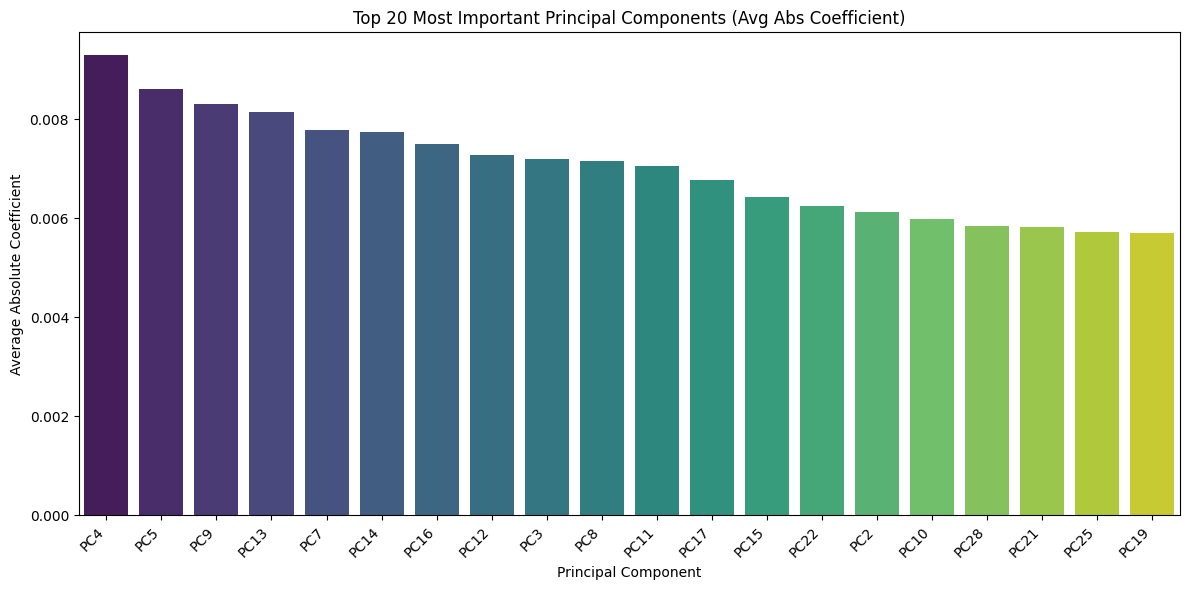

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Analyzing Feature Importance (Principal Components) ---")

if 'best_log_reg' in locals() and DATA_LOADED_FROM_SAVE:
    # 1. Get Coefficients
    # For multi-class LR, coef_ has shape (n_classes, n_features)
    coefficients = best_log_reg.coef_
    
    # 2. Calculate Average Absolute Importance per PC
    # We take the absolute value (magnitude matters) and average across all classes
    avg_abs_coef = np.mean(np.abs(coefficients), axis=0)
    
    # Create a DataFrame for easier handling
    pc_importance = pd.DataFrame({
        'PC_Index': range(avg_abs_coef.shape[0]),
        'Importance': avg_abs_coef
    })
    
    # Add PC names like 'PC1', 'PC2', ... (indices start from 0)
    pc_importance['PC_Name'] = pc_importance['PC_Index'].apply(lambda x: f'PC{x+1}')
    
    # 3. Sort by Importance
    pc_importance = pc_importance.sort_values(by='Importance', ascending=False)
    
    print("\nTop 20 Most Important Principal Components:")
    print(pc_importance.head(20)[['PC_Name', 'Importance']])
    
    # 4. Plot the Importance
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=pc_importance.head(20), 
        x='PC_Name', 
        y='Importance',
        palette='viridis' # Use a nice color map
        )
    plt.title('Top 20 Most Important Principal Components (Avg Abs Coefficient)')
    plt.xlabel('Principal Component')
    plt.ylabel('Average Absolute Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print("Optimized Logistic Regression model ('best_log_reg') not found.")
    print("Please run the loader cell and the GridSearchCV cell")

In [17]:
import numpy as np
import pandas as pd

print("--- Mapping Top PCs to Original Features (Approximation) ---")

if 'pca' in locals() and 'all_feature_names' in locals() and 'pc_importance' in locals():

    # How many top PCs to analyze?
    N_TOP_PCS = 3
    # How many top original features to show per PC?
    N_TOP_FEATURES_PER_PC = 10

    print(f"Analyzing the top {N_TOP_PCS} Principal Components...")

    # Get the names and indices of the top PCs from the pc_importance DataFrame
    top_pc_names = pc_importance['PC_Name'].head(N_TOP_PCS).tolist()
    top_pc_indices = pc_importance['PC_Index'].head(N_TOP_PCS).tolist()

    # pca.components_ has shape (n_components, n_features_original)
    # Each row contains the loadings for one PC across all original features

    for i, pc_index in enumerate(top_pc_indices):
        pc_name = top_pc_names[i]

        # Get the loadings for this specific PC
        loadings = pca.components_[pc_index]

        # Get the absolute loadings and sort them
        abs_loadings = np.abs(loadings)
        sorted_indices = np.argsort(abs_loadings)[::-1] # Sort descending

        print(f"\n--- Top {N_TOP_FEATURES_PER_PC} Original Features Contributing to {pc_name} ---")

        for j in range(N_TOP_FEATURES_PER_PC):
            original_feature_index = sorted_indices[j]
            # Ensure the index is within bounds (safety check)
            if original_feature_index < len(all_feature_names):
                original_feature_name = all_feature_names[original_feature_index]
                loading_value = loadings[original_feature_index] # Keep the original sign
                print(f"  {j+1}. {original_feature_name}: {loading_value:.4f}")
            else:
                print(f"  Warning: Index {original_feature_index} out of bounds for feature names.")


else:
    print("Required variables ('pca', 'all_feature_names', 'pc_importance') not found.")
    print("Please ensure the loader, PCA, and PCA importance cells have run.")

--- Mapping Top PCs to Original Features (Approximation) ---
Required variables ('pca', 'all_feature_names', 'pc_importance') not found.
Please ensure the loader, PCA, and PCA importance cells have run.
